# GP Regression (CUDA) with Fast Predictive Distributions (LOVE)

## Overview

In this notebook, we demonstrate that LOVE (the method for fast variances and sampling introduced in this paper https://arxiv.org/abs/1803.06058 and the `fast_variances_ski_LOVE.ipynb`) can significantly reduce the cost of computing predictive distributions with exact GPs too. This can be especially useful in settings like small-scale Bayesian optimization, where predictions need to be made at enormous numbers of candidate points, but there aren't enough training examples to necessarily warrant the use of sparse GP methods.

In this notebook, we will train an exact GP on the `skillcraft `UCI dataset, and then compare the time required to make predictions with each model.

**NOTE**: The timing results reported in the paper compare the time required to compute (co)variances __only__. Because excluding the mean computations from the timing results requires hacking the internals of GPyTorch, the timing results presented in this notebook include the time required to compute predictive means, which are not accelerated by LOVE. Nevertheless, as we will see, LOVE achieves impressive speed-ups.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

### Loading Data

For this example notebook, we'll be using the `skillcraft` UCI dataset used in the paper. Running the next cell downloads a copy of the dataset that has already been scaled and normalized appropriately. For this notebook, we'll simply be splitting the data using the first 40% of the data as training and the last 60% as testing.

**Note**: Running the next cell will attempt to download a small dataset file to the current directory.

In [2]:
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor

if not os.path.isfile('skillcraft.mat'):
    print('Downloading \'skillcraft\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')
    
data = torch.Tensor(loadmat('skillcraft.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.4*len(X)))

train_x = X[:train_n, :].contiguous().cuda()
train_y = y[:train_n].contiguous().cuda()

test_x = X[train_n:, :].contiguous().cuda()
test_y = y[train_n:].contiguous().cuda()

## Defining the GP Model

We now define the GP model. The model below is essentially the same as the model in the `simple_gp_regression` example, with an added log outputscale.

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            )
            
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = GPRegressionModel(train_x, train_y, likelihood).cuda()

## Training the model

The cell below trains the GP model, finding optimal hyperparameters using Type-II MLE. We run 20 iterations of training using the `Adam` optimizer built in to PyTorch. With a decent GPU, this should only take a few seconds.

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 20
def train():
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1,
                                           training_iterations,
                                           loss.item()))
        optimizer.step()
        
%time train()

/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:66: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


Iter 1/20 - Loss: 1.058
Iter 2/20 - Loss: 0.998
Iter 3/20 - Loss: 0.934
Iter 4/20 - Loss: 0.876
Iter 5/20 - Loss: 0.824
Iter 6/20 - Loss: 0.770
Iter 7/20 - Loss: 0.717
Iter 8/20 - Loss: 0.675
Iter 9/20 - Loss: 0.628
Iter 10/20 - Loss: 0.582
Iter 11/20 - Loss: 0.536
Iter 12/20 - Loss: 0.494
Iter 13/20 - Loss: 0.453
Iter 14/20 - Loss: 0.417
Iter 15/20 - Loss: 0.383
Iter 16/20 - Loss: 0.346
Iter 17/20 - Loss: 0.311
Iter 18/20 - Loss: 0.280
Iter 19/20 - Loss: 0.252
Iter 20/20 - Loss: 0.222
CPU times: user 435 ms, sys: 78.8 ms, total: 513 ms
Wall time: 512 ms


## Make Predictions using Standard SKI Code

The next cell gets the predictive covariance for the test set (and also technically gets the predictive mean, stored in `preds.mean`) using the standard SKI testing code, with no acceleration or precomputation. 

**Note:** Full predictive covariance matrices (and the computations needed to get them) can be quite memory intensive. Depending on the memory available on your GPU, you may need to reduce the size of the test set for the code below to run. If you run out of memory, try replacing `test_x` below with something like `test_x[:1000]` to use the first 1000 test points only, and then restart the notebook.

In [50]:
model.train()
output = model(train_x)

In [54]:
foo = output.lazy_covariance_matrix.evaluate_kernel().base_lazy_tensor.evaluate_kernel()

In [110]:
model.covar_module.base_kernel.log_lengthscale.data.fill_(-1.2)
foo_eval = model.covar_module.base_kernel(train_x).evaluate()

In [112]:
bar = foo_eval.view(-1).clone()
bar[bar < 0.98] = 0
bar_eval = bar.view(*foo.shape)

Text(0,0.5,'Singular Value (\\sigma_{i})')

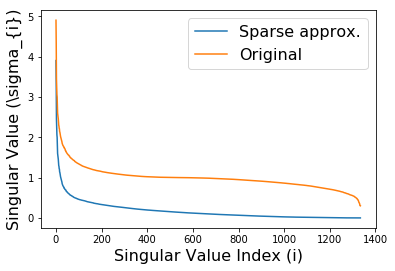

In [113]:
plt.plot(((foo_eval - bar_eval).svd()[1]).detach().cpu().numpy(), label='Sparse approx.')
plt.plot(foo_eval.svd()[1].detach().cpu().numpy(), label='Original')
plt.legend(fontsize=16)
plt.xlabel('Singular Value Index (i)', fontsize=16)
plt.ylabel('Singular Value (\sigma_{i})', fontsize=16)

In [6]:
import time

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    preds = model(test_x)
    exact_covar = preds.covariance_matrix
    exact_covar_time = time.time() - start_time

/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:66: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


In [7]:
print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))

Time to compute exact mean + covariances: 0.07s


## Clear Memory and any Precomputed Values

The next cell clears as much as possible to avoid influencing the timing results of the fast predictive variances code. Strictly speaking, the timing results above and the timing results to follow should be run in entirely separate notebooks. However,  this will suffice for this simple example.

In [8]:
# Clear as much 'stuff' as possible
import gc
gc.collect()
torch.cuda.empty_cache()
model.train()
likelihood.train()

GaussianLikelihood()

## Compute Predictions with LOVE, but Before Precomputation

Next we compute predictive covariances (and the predictive means) for LOVE, but starting from scratch. That is, we don't yet have access to the precomputed cache discussed in the paper. This should still be faster than the full covariance computation code above.

To use LOVE, use the context manager `with gpytorch.fast_pred_var():`

You can also set some of the LOVE settings with context managers as well. For example, `gpytorch.settings.max_root_decomposition_size(35)` affects the accuracy of the LOVE solves (larger is more accurate, but slower).

In this simple example, we allow a rank 10 root decomposition, although increasing this to rank 20-40 should not affect the timing results substantially.

In [9]:
# Set into eval mode
model.eval()
likelihood.eval()

# The 
with torch.no_grad(), gpytorch.beta_features.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(25):
    start_time = time.time()
    preds = model(test_x)
    fast_time_no_cache = time.time() - start_time

/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:66: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


## Compute Predictions with LOVE After Precomputation

The above cell additionally computed the caches required to get fast predictions. From this point onwards, unless we put the model back in training mode, predictions should be extremely fast. The cell below re-runs the above code, but takes full advantage of both the mean cache and the LOVE cache for variances.

In [10]:
with torch.no_grad(), gpytorch.beta_features.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(25):
    start_time = time.time()
    preds = model(test_x)
    fast_covar = preds.covariance_matrix
    fast_time_with_cache = time.time() - start_time

In [11]:
print('Time to compute mean + covariances (no cache) {:.2f}s'.format(fast_time_no_cache))
print('Time to compute mean + variances (cache): {:.2f}s'.format(fast_time_with_cache))

Time to compute mean + covariances (no cache) 0.07s
Time to compute mean + variances (cache): 0.01s


## Compute Error between Exact and Fast Variances

Finally, we compute the mean absolute error between the fast variances computed by LOVE (stored in fast_covar), and the exact variances computed previously. 

Note that these tests were run with a root decomposition of rank 10, which is about the minimum you would realistically ever run with. Despite this, the fast variance estimates are quite good. If more accuracy was needed, increasing `max_root_decomposition_size` to 30 or 40 would provide even better estimates.

In [12]:
print('MAE between exact covar matrix and fast covar matrix: {}'.format((exact_covar - fast_covar).abs().mean()))

MAE between exact covar matrix and fast covar matrix: 2.8388076316332445e-05
